In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
 
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/BERT/.kaggle/'
 
# Set working path
mywd = '/content/drive/My Drive/Colab Notebooks/BERT/'
#mywd = "C:/Users/jeff7/jupyter/BERT"
os.chdir(mywd)
os.getcwd()

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
 
!kaggle competitions download -c petfinder-adoption-prediction

In [ ]:
!unzip petfinder-adoption-prediction.zip -d /input/petfinder-adoption-prediction

In [ ]:
!pip install transformers

In [ ]:
# standard imports
import time
import random
import numpy as np
import pandas as pd
import gc
from sklearn import metrics
from sklearn import preprocessing
import glob
from PIL import Image
import matplotlib.pyplot as plt

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.utils.checkpoint as checkpoint
from torchvision import transforms, models

# imports for preprocessing the questions
from transformers import BertTokenizer, BertPreTrainedModel, BertModel

# progress bars
from tqdm import tqdm
tqdm.pandas()

In [2]:
from contextlib import contextmanager
import time

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    

FILE_DIR = 'input/petfinder-adoption-prediction'
    
TRAIN_PATH = f'{FILE_DIR}/train/train.csv'
TEST_PATH = f'{FILE_DIR}/test/test.csv'
SAMPLE_SUBMISSION_PATH = f'{FILE_DIR}/test/sample_submission.csv'

maxlen = 50
max_namelen = 5

max_features = 95000
batch_size = 512
seed = 1018

def seed_torch(seed=seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch()

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
train_label = train_df['AdoptionSpeed'].values

In [4]:
def preprocess_text(text):
    punct = [ '"', ')', '(', '-', '|', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
        '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾']
    for p in punct:
        text = text.replace(p, f' {p} ')
    return text

train_df['Description'] = train_df['Description'].astype(str)
test_df['Description'] = test_df['Description'].astype(str)
train_df['Description'] = train_df['Description'].progress_apply(preprocess_text)
test_df['Description'] = test_df['Description'].progress_apply(preprocess_text)

train_df['Name'] = train_df['Name'].astype(str)
test_df['Name'] = test_df['Name'].astype(str)
train_df['Name'] = train_df['Name'].progress_apply(preprocess_text)
test_df['Name'] = test_df['Name'].progress_apply(preprocess_text)

100%|███████████████████████████████████████████████████████████████████████████| 3972/3972 [00:00<00:00, 52941.79it/s]


In [5]:
train_id = train_df['PetID']
test_id = test_df['PetID']

train_text = train_df[['Name', 'Description']].agg(' '.join, axis=1)
test_text = test_df[['Name', 'Description']].agg(' '.join, axis=1)

In [6]:
### Name, RescuerID, Description, PetID were not included
all_categories = ['Type','Age','Breed1','Breed2','Gender',
                  'Color1','Color2','Color3',
                  'MaturitySize','FurLength','Vaccinated',
                  'Dewormed','Sterilized','Health',
                  'Quantity','Fee','State',
                  'VideoAmt','PhotoAmt']

for category in tqdm(all_categories):
    dtype = train_df[category].dtype
    print(train_df[category].dtype, category)
    
    if dtype == 'int64':
        train_df[category] = train_df[category].fillna(-1)
        test_df[category] = test_df[category].fillna(-1)
    elif dtype == 'float64':
        train_df[category] = train_df[category].fillna(-1.0)
        test_df[category] = test_df[category].fillna(-1.0)
    else:
        train_df[category] = train_df[category].fillna('unknown')
        test_df[category] = test_df[category].fillna('unknown')

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1187.25it/s]

int64 Type
int64 Age
int64 Breed1
int64 Breed2
int64 Gender
int64 Color1
int64 Color2
int64 Color3
int64 MaturitySize
int64 FurLength
int64 Vaccinated
int64 Dewormed
int64 Sterilized
int64 Health
int64 Quantity
int64 Fee
int64 State
int64 VideoAmt
float64 PhotoAmt


In [7]:
one_hot_categories = ['Type','Breed1','Breed2','Gender',
                      'Color1','Color2','Color3','State']

def pandas_get_dummies(column, df_train, df_test):
    merged = pd.concat([df_train[column], df_test[column]], axis = 0)
    train_size = df_train.shape[0]
    merged_dummies = pd.get_dummies(merged.astype(str), prefix=column)
    return merged_dummies[:train_size], merged_dummies[train_size:]

train_df_one_hot, test_df_one_hot = pandas_get_dummies(one_hot_categories, train_df, test_df)

In [8]:
ordinal_categories = ['Age','MaturitySize','FurLength','Vaccinated','Dewormed','Sterilized',
                      'Health','Quantity','Fee','VideoAmt','PhotoAmt']

def pandas_mean_normalizer(df):
    return (df-df.mean()) / df.std()

def pandas_min_max_normalizer(df):
    return (df-df.min()) / (df.max()-df.min())

train_df_ordinal = pandas_mean_normalizer(train_df[ordinal_categories])
test_df_ordinal = pandas_mean_normalizer(test_df[ordinal_categories])

In [9]:
train_tabular = pd.concat([train_df_ordinal, train_df_one_hot], axis = 1)
test_tabular = pd.concat([test_df_ordinal, test_df_one_hot], axis = 1)

In [10]:
class TotalDataset(torch.utils.data.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path, IDs, Text, Tabular, Label=None):
        """ Intialize the dataset
        """
        self.Tabular, self.Label = Tabular, Label
        
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        inputs = tokenizer(list(Text), return_tensors="pt",
                            max_length=100, padding=True, truncation=True)
        self.input_ids = inputs['input_ids']
        self.token_type_ids = inputs['token_type_ids']
        self.attention_mask = inputs['attention_mask']
        
        self.transform = transforms.Compose([
                            transforms.Resize(256),
                            transforms.RandomCrop(224),
                            transforms.ToTensor(),                            
                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                        ])
    
        filenames = glob.glob(path + '*.jpg')        
        tmp_filenames = []
        for image_path in filenames:
            tmp_filenames.append(image_path.split('\\')[-1].split('-')[0])
        
        self.filenames = []
        for ID in IDs:
            try:
                self.filenames.append(filenames[tmp_filenames.index(ID)])
            except:
                self.filenames.append(np.nan)
                
        self.len = len(self.filenames)
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        try:
            image = Image.open(self.filenames[index])
            image = self.transform(image)
        except:
            image = Image.new('RGB', (224,224))
            image = self.transform(image)
        
        if(self.Label is not None):       
            return self.Label[index], self.Tabular[index], image, self.input_ids[index], self.token_type_ids[index], self.attention_mask[index]
        else:
            return self.Tabular[index], image, self.input_ids[index], self.token_type_ids[index], self.attention_mask[index]
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [11]:
train_image_path = "input\\petfinder-adoption-prediction\\train_images\\"
test_image_path = "input\\petfinder-adoption-prediction\\test_images\\"

L = len(train_label)
index = np.random.choice(np.arange(L), size = L, replace = False)
train_index = index[:-2000]
val_index = index[-2000:]

train_ds = TotalDataset(train_image_path, train_id[train_index], train_text[train_index], np.array(train_tabular)[train_index], train_label[train_index])
val_ds = TotalDataset(train_image_path, train_id[val_index], train_text[val_index], np.array(train_tabular)[val_index], train_label[val_index])
#test_ds = TotalDataset(test_image_path, test_id, test_text, np.array(test_tabular))

train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_ds, batch_size=50)
#test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=20)

In [12]:
np.array(train_tabular).shape

(14993, 381)

In [13]:
np.unique(train_label)

array([0, 1, 2, 3, 4], dtype=int64)

In [ ]:
class Bert_CNN_Tabular_Classification(nn.Module):
    
    def __init__(self):
        super(Bert_CNN_Tabular_Classification, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        bert_out_features = 768
        for param in self.bert.parameters():
            param.requires_grad = False
        
        cnn_out_features = 500
        self.cnn = models.resnet50(pretrained=True)
        for param in self.cnn.parameters():
            param.requires_grad = False
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, cnn_out_features)        
        
        tabular_features = 381
        self.classifier = nn.Linear(bert_out_features + cnn_out_features + tabular_features, 5)

    def forward(
        self,
        input_tabular=None,
        input_image=None,        
        input_ids=None,
        attention_mask=None,
        token_type_ids=None):
        
        sequence_output, pooled_output = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        text_output = self.dropout(pooled_output)
        
        image_output = self.cnn(input_image)
    
        total = torch.cat([text_output, image_output, input_tabular.float()], axis = 1)
        
        logits = self.classifier(total)

        return logits

In [15]:
def train(net, train_data, test_data, num_epochs, optimizer, criterion, File_path):
    
    AlltStart = time.time()#計時開始
    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    test_loss = np.zeros(num_epochs)
    test_acc = np.zeros(num_epochs)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    criterion.to(device)
        
    for epoch in range(num_epochs):
        tStart = time.time()#計時開始
        net = net.train()
        for data in tqdm(train_data):
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            data = [t.to(device) for t in data if t is not None]
            labels, tabular, image, tokens_tensors, segments_tensors, masks_tensors = data
            outputs = model(input_tabular=tabular,
                            input_image=image,
                            input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)

            loss = criterion(outputs, labels)
            #loss = criterion(outputs.cpu(), labels.cpu())
            
            # backward
            loss.backward()
            optimizer.step()
            
            train_loss[epoch] += float(loss.data)
            train_acc[epoch] += get_acc(outputs, labels)

        if test_data is not None:
            net = net.eval()
            for data in tqdm(test_data):
                data = [t.to(device) for t in data if t is not None]
                labels, tabular, image, tokens_tensors, segments_tensors, masks_tensors = data
                outputs = model(input_tabular=tabular,
                                input_image=image,
                                input_ids=tokens_tensors, 
                                token_type_ids=segments_tensors, 
                                attention_mask=masks_tensors)

                loss = criterion(outputs, labels)
                #loss = criterion(outputs.cpu(), labels.cpu())
                
                test_loss[epoch] += float(loss.data)
                test_acc[epoch] += get_acc(outputs, labels)
                
            tEnd = time.time()#計時結束
            
            epoch_str = (
                "Epoch %d. %.2f sec. Train Loss: %f, Train Acc: %f, Test Loss: %f, Test Acc: %f, "
                % (epoch,
                   (tEnd - tStart),
                   train_loss[epoch] / len(train_data),
                   train_acc[epoch] / len(train_data),
                   test_loss[epoch] / len(test_data),
                   test_acc[epoch] / len(test_data)))
            
        else:
            tEnd = time.time()#計時結束
            epoch_str = ("Epoch %d. %.2f sec. Train Loss: %f, Train Acc: %f, " %
                         (epoch, (tEnd - tStart), train_loss[epoch] / len(train_data),
                          train_acc[epoch] / len(train_data)))
            
        print(epoch_str)
        
    AlltEnd = time.time()#計時結束
    print("Totally cost %d min %.2f sec" % ((AlltEnd - AlltStart)//60, (AlltEnd - AlltStart)%60))
    
    file_data = pd.DataFrame(data = (np.vstack((train_loss/len(train_data), train_acc/len(train_data), test_loss/len(test_data), test_acc/len(test_data)))).T)
    file_data.to_csv(File_path, encoding = "utf-8")
    
    plt.figure()
    plt.plot(train_loss / len(train_data))
    plt.plot(test_loss / len(test_data))
    plt.legend(['train_loss', 'test_loss'], loc = "best", frameon = False)
    plt.title(' Training/testing loss')
    plt.show()
    
    plt.figure()
    plt.plot(train_acc/ len(train_data))
    plt.plot(test_acc / len(test_data))
    plt.legend(['train_acc', 'test_acc'], loc = "best", frameon = False)
    plt.title(' Training/testing accuracy')
    plt.show()

def test(net, test_data):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net = net.eval()
    predictions = None
    Total_num_correct = 0
    Total_num = 0
    for data in tqdm(test_data):
        data = [t.to(device) for t in data if t is not None]
        labels, tabular, image, tokens_tensors, segments_tensors, masks_tensors = data
        outputs = model(input_tabular=tabular,
                        input_image=image,
                        input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors)

        _, pred_labels = outputs.max(1)
        if predictions is None:
            predictions = pred_labels
        else:
            predictions = torch.cat((predictions, pred_labels))

        Total_num += outputs.size(0)
        Total_num_correct += ((pred_labels == labels).sum().data).float()
            
    print("Test accuracy %f " % (Total_num_correct/Total_num))
            
    return predictions


def get_acc(outputs, labels):
    total = outputs.size(0)
    _, pred_labels = outputs.max(1)
    num_correct = ((pred_labels == labels).sum().data).float()
    return num_correct / total


def count_params(model):
    count = 0
    for layer_tensor_name, tensor in model.named_parameters():
        count += torch.numel(tensor)
        print('Layer {}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))
    print("Total parameters = %d" % count)

In [16]:
def Weighted_Kappa_Loss(logits, labels, num_classes=5, epsilon=1e-10):
    probas = torch.nn.functional.softmax(logits.float(), 0).float()
    labels = torch.nn.functional.one_hot(labels, num_classes).float()
    repeat_op = torch.arange(0, num_classes).view(num_classes, 1).repeat(1, num_classes).float()
    repeat_op_sq = torch.pow((repeat_op - repeat_op.transpose(0, 1)), 2)
    weights = repeat_op_sq / (num_classes - 1) ** 2

    pred_ = probas ** 2
    pred_norm = pred_ / (epsilon + pred_.sum(1).view(-1, 1))

    hist_rater_a = pred_norm.sum(0)
    hist_rater_b = labels.sum(0)
    conf_mat = torch.matmul(pred_norm.transpose(0, 1), labels)

    nom = (weights * conf_mat).sum()
    denom = (weights * torch.matmul(hist_rater_a.view(num_classes, 1), hist_rater_b.view(1, num_classes)) / labels.shape[0]).sum()
    return nom / (denom + epsilon)

In [17]:
model = Bert_CNN_Tabular_Classification()

#print(model)
#count_params(model)

  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 0. 141.19 sec. Train Loss: 1.413428, Train Acc: 0.349638, Test Loss: 1.384730, Test Acc: 0.383000, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 1. 140.83 sec. Train Loss: 1.368375, Train Acc: 0.383225, Test Loss: 1.375476, Test Acc: 0.383500, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 2. 140.45 sec. Train Loss: 1.349012, Train Acc: 0.393803, Test Loss: 1.385557, Test Acc: 0.372500, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 3. 141.71 sec. Train Loss: 1.344185, Train Acc: 0.407275, Test Loss: 1.364523, Test Acc: 0.410500, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 4. 140.27 sec. Train Loss: 1.330550, Train Acc: 0.404930, Test Loss: 1.365810, Test Acc: 0.388000, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 5. 139.83 sec. Train Loss: 1.324445, Train Acc: 0.417342, Test Loss: 1.359117, Test Acc: 0.404000, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 6. 139.49 sec. Train Loss: 1.318804, Train Acc: 0.418483, Test Loss: 1.381138, Test Acc: 0.382500, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 7. 139.40 sec. Train Loss: 1.313604, Train Acc: 0.420252, Test Loss: 1.374837, Test Acc: 0.401500, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 8. 139.54 sec. Train Loss: 1.309578, Train Acc: 0.423790, Test Loss: 1.398316, Test Acc: 0.373500, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 9. 138.80 sec. Train Loss: 1.311363, Train Acc: 0.423982, Test Loss: 1.372702, Test Acc: 0.388000, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 10. 138.86 sec. Train Loss: 1.302505, Train Acc: 0.421290, Test Loss: 1.367501, Test Acc: 0.394500, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 11. 139.16 sec. Train Loss: 1.297394, Train Acc: 0.432071, Test Loss: 1.368343, Test Acc: 0.394000, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 12. 138.79 sec. Train Loss: 1.300094, Train Acc: 0.428199, Test Loss: 1.374760, Test Acc: 0.384000, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 13. 138.93 sec. Train Loss: 1.295174, Train Acc: 0.428558, Test Loss: 1.380978, Test Acc: 0.396000, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 14. 138.97 sec. Train Loss: 1.295711, Train Acc: 0.427520, Test Loss: 1.382381, Test Acc: 0.386500, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 15. 139.08 sec. Train Loss: 1.291813, Train Acc: 0.428021, Test Loss: 1.383109, Test Acc: 0.393500, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 16. 139.06 sec. Train Loss: 1.288555, Train Acc: 0.428508, Test Loss: 1.384474, Test Acc: 0.384000, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 17. 138.92 sec. Train Loss: 1.289111, Train Acc: 0.432392, Test Loss: 1.378837, Test Acc: 0.390500, 


  0%|                                                                                          | 0/260 [00:00<?, ?it/s]

Epoch 18. 139.27 sec. Train Loss: 1.285327, Train Acc: 0.434789, Test Loss: 1.406310, Test Acc: 0.385000, 


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.23it/s]

Epoch 19. 139.03 sec. Train Loss: 1.285525, Train Acc: 0.438213, Test Loss: 1.402613, Test Acc: 0.380500, 
Totally cost 46 min 33.22 sec


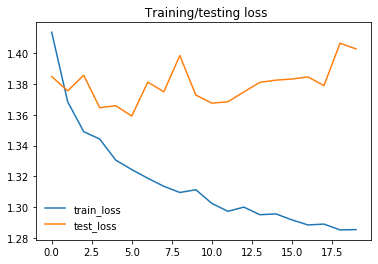

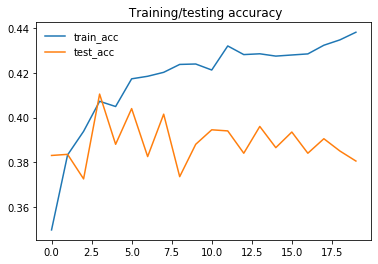

In [18]:
optimizer = torch.optim.Adam(model.parameters()) 
criterion = nn.CrossEntropyLoss()
#criterion = Weighted_Kappa_Loss
#criterion = nn.MSELoss()
epoch_num = 20

train(model, train_loader, val_loader, epoch_num, optimizer, criterion, "./Try.csv")

#gc.collect()
#torch.cuda.empty_cache()

In [19]:
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [20]:
predictions = test(model, val_loader)

del model
#del train_ds
#del train_loader
#del val_ds
#del val_loader
gc.collect()
torch.cuda.empty_cache()

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.69it/s]


Test accuracy 0.385500 


In [21]:
accuracy = (predictions.cpu().numpy() == train_label[val_index]).sum() / len(train_label[val_index])
qwk = quadratic_weighted_kappa(train_label[val_index], predictions.cpu().numpy())
print(accuracy)
print(qwk)

0.3855
0.28847422564070824


In [22]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(train_label[val_index], predictions.cpu().numpy(), weights='quadratic')

0.28847422564070835

In [23]:
0.383
0.31500610367057946

0.31500610367057946